# Getting elemental maps from EELS data using eXSpy

In this tutorial, elemental maps of copper and zinc will be created from electron energy loss spectra (EELS). The data is recorded using a sample of copper and zinc oxide deposited on carbon nanotubes. The particles are likely to be very small, and the carbon is not completely covered. In this sample, the ratio of Zn and Cu is 3:1, and approximately 80 wt% of the sample is carbon. Due to the small amount of copper and zinc, the signal strength is low. To improve the signal strength without lowering the spatial resolution, the spectra were recorded with a high energy dispersion, resulting in low energy resolution. This means that any fine structure is not visible.

For more information about the material system and how the results of this processing can be used, see the paper: https://doi.org/10.1016/j.cattod.2019.02.045

This notebook requires `HyperSpy` 2.0 or higher. It also requires `eXSpy` which is a library which contains all of HyperSpy's EELS and EDX functionality.

The main objective is to show how the functionalities of `HyperSpy` and `eXSpy` can be used to create relative elemental maps from EEL spectra.

### Changes

* 2017/09/27: Initial version by Ida Hjorth
* 2019/11/14: Update to HyperSpy 1.5, and minor improvements to text by Magnus Nord
* 2024/3/16: Update to work with HyperSpy 2.0, by Magnus Nord

### Table of contents

1. <a href='#load'> Load data</a> 
2. <a href='#fitting'>Fitting Cu and Zn core-loss edges</a>
3. <a href='#export_maps'>Display and export elemental maps</a>
4. <a href='#save_restore'>Saving and restoring the model</a>

# <a id='load'></a>1. Load data

In [1]:
%matplotlib widget
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt

In core loss EELS data such as this, we typically have two major types of features: the plasmon background and the core loss edges. The core loss edges originates from specific elements, and can be used to estimate the amount of that element. The plasmon background originates from collective electron motions in the material, and needs to be removed before the element amount can be estimated. This background removal is typically done by fitting a power law to the region before the core loss edge.

However, if an EEL spectrum has two or more core loss edges, the intensity from the core loss edge situated at a lower energy must be accounted for somehow if we want to get the intensity from the edge at higher energy.

In many cases, this can be done by fitting a power law to the region in front of the high energy core loss edge. However, if the two core loss edges are too close to each other, we need to use another approach.

In this dataset, the Cu (around 930 eV) and Zn edges (around 1040 eV), are too close to estimate the background for the Zn edge. A solution to this problem is to fit the background and edges as shown in this notebook: the model based approach.

In [2]:
s_eels = hs.load('datasets/CuZn_EELS_mapping_tutorial.hspy')

Visualise the data using `plot()`, and navigate to a region where both edges are visible. For example position `(32, 14)`. Move the navigator in the `EELS Spectrum Image Navigator` either by:

- left-click and drag the red "box" in the `EELS Spectrum Image Navigator`
- select the `EELS Spectrum Image Navigator` window/figure and use the `Ctrl` + `Arrow` keys on your keyboard,
- or hold the `Shift` key on your keyboard and left click on the location you want to navigate to.

To compare two spectra from different positions, select either one of the figures and press the `E` key on your keyboard. This will add an extra blue navigator "box", which is moved by left-click + dragging it.

In [3]:
s_eels.plot()

Now, lets try to visualize the intensity from both of the core loss edges, without having removed the plasmon background.

We do this using by using `hs.plot.plot_roi_map`. Move and resize the red and green spans by click-and-dragging with your mouse. The red span should be from about 930 to 1005 eV, and the green from 1045 to 1145 eV.

You should be able to see some small changes, but due to the large contribution from the plasmon background it is difficult.

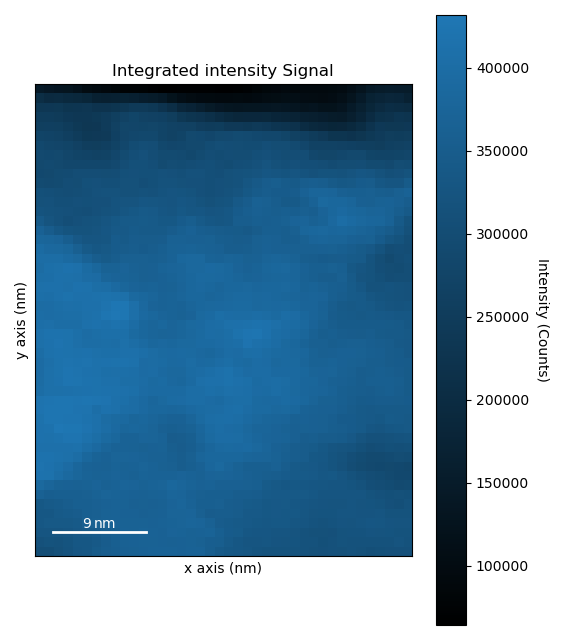

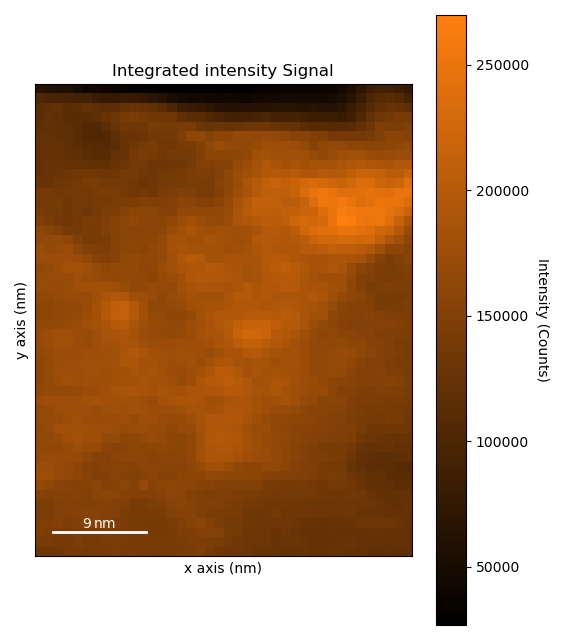

([SpanROI(left=700, right=1022), SpanROI(left=1022, right=1344)],
 [<Signal2D, title: Integrated intensity, dimensions: (|40, 50)>,
  <Signal2D, title: Integrated intensity, dimensions: (|40, 50)>])

In [4]:
hs.plot.plot_roi_map(s_eels, rois=2)

To improve this, we remove the plasmon background by fitting a power law background to the region in front of the Cu core loss edge. From 700 to 900 eV.

In [5]:
s_eels_background_removed = s_eels.remove_background(signal_range=(700., 900.), fast=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

Then, we do the same visualization as earlier: using `hs.plot.plot_roi_map`, placing the red span at 930 to 1005 eV, and the green span at 1045 to 1145 eV.

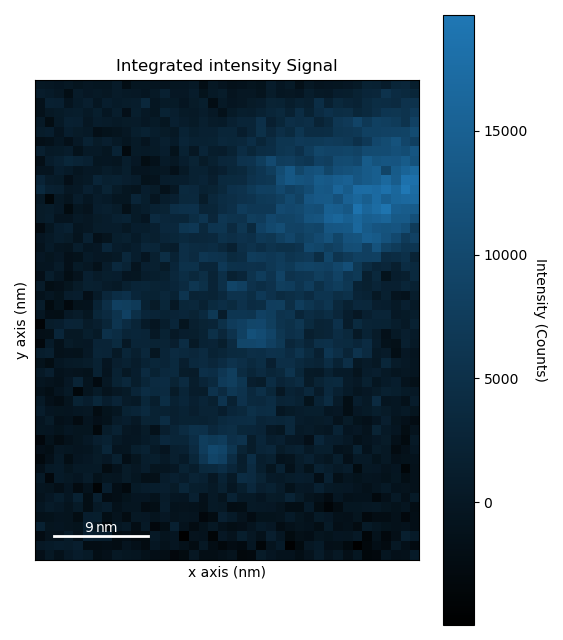

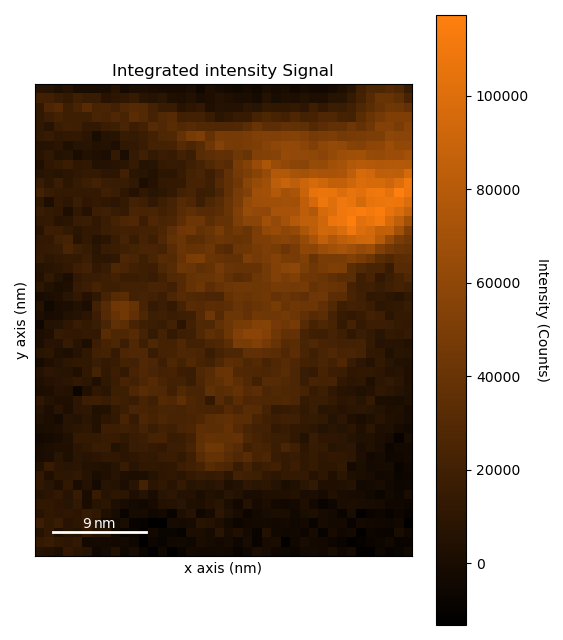

([SpanROI(left=700, right=1022), SpanROI(left=1022, right=1344)],
 [<Signal2D, title: Integrated intensity, dimensions: (|40, 50)>,
  <Signal2D, title: Integrated intensity, dimensions: (|40, 50)>])

In [6]:
hs.plot.plot_roi_map(s_eels_background_removed, rois=2)

Now, the intensity from the plasmons is greatly reduced, with the Cu and Zn edges being much more visible. However, wherever there is Cu (red), there is also Zn (green). So currently, we can't be sure if the Cu core loss edge contributes to the apparent amount of Zn (due to the edges overlapping), or if it is due Cu and Zn being in the same regions.

To properly resolve this, we need to use the model based approach, by fitting a component to all the features: the plasmon background, the Cu core loss edge and the Zn core loss edge.

# <a id='fitting'></a>2. Fitting Cu and Zn core-loss edges

In the model-based approach, the low-loss signal can be convolved with the high-loss signal such that the energy spread of the electron beam and plural scattering due to the bulk plasmon are taken into account. This will lead to a better fit of the model to the experimental data. In addition, the experimental zero loss peak can be used to precisely calibrate the energy scale. 

In this example the low-loss signal was not recorded. However, since the sample is fairly thin, the effect of plural scattering is negligible.

------

**Note**: this will download a set of open source **Generalised Oscillator Strengths (GOS)** , which was computed and packaged by Leonhard Segger, Giulio Guzzinati and Helmut Kohl. For more information about the GOS files, see the [Zenodo deposit](https://zenodo.org/doi/10.5281/zenodo.6599070). For more information about how these were computed, and the code used to compute them, see https://github.com/Br0Fi/goscalc. The GOS will be used to calculate the double differential cross-section and quantify the elemental distribution.

Now, we will make a model containing a power law background and the Cu and Zn cross sections. To do this, we first have to set the experimental parameters.

In [7]:
s_eels.set_microscope_parameters(beam_energy=200, convergence_angle=13.33, collection_angle=55.28) 
s_eels.add_elements(('Cu', 'Zn')) 
m = s_eels.create_model()

Both the power law background and core less edge components (`EELSCLEdge`) has automatically been added.

In [8]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            PowerLaw |            PowerLaw |            PowerLaw
   1 |               Zn_L3 |               Zn_L3 |          EELSCLEdge
   2 |               Zn_L2 |               Zn_L2 |          EELSCLEdge
   3 |               Zn_L1 |               Zn_L1 |          EELSCLEdge
   4 |               Cu_L3 |               Cu_L3 |          EELSCLEdge
   5 |               Cu_L2 |               Cu_L2 |          EELSCLEdge
   6 |               Cu_L1 |               Cu_L1 |          EELSCLEdge

Due to the large intensity variations across the dataset, the different features are fitted one by one within limited energy ranges. After having run the fitting for the individual features, all of them will be fitted at the same time.

Here, we use the `model.fit_component` method for doing the initial fitting of the individual features. It works by passing the component we want to fit, and the energy range where we want to do this fitting through the `signal_range` parameter. In addition, we set `only_current=False` to fit all the probe positions.

**Tip:** you can use docstrings to learn how functions work. These are accessed by having a question mark behind the function, for example `m.fit_component?`. If you're using JupyterLab, you can also press the `Shift` + `Tab` keys on your keyboard while the function is selected in a code cell.

We start with the power law component, and fit it from the start of the spectrum (700 eV) to right before the first (Cu) core loss edge (900 eV).

In [9]:
m.fit_component(m.components.PowerLaw, signal_range=(700, 900), only_current=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

Now, we visualise the model to see how well the fitting went.

The model consist of several components, so we use `plot_components=True` to see the individual components. Here, the red dots are the experimental data, the blue line is the whole model, and the green line is the power law we just fitted. There are also several other components shown in the figure: the Cu and Zn core loss edges. When added, they start with an initial non-zero value, so don't worry that they currently do not fit very well with the data.

In [10]:
m.plot(plot_components=True)

Then we use `fit_component` again, to fit the first of the core loss edges: Cu. Here, we want the energy range which contains just power law (which we already fitted), and the Cu-L$_{2,3}$ edges. For example from 950 to 1000 eV. Again, we use `only_current=False` to fit all the probe positions.

In [11]:
m.fit_component(m.components.Cu_L3, signal_range=(950, 1000), only_current=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

Then we repeat this for Zn-L$_{2,3}$, for signal range 1050 to 1150 eV.

In [12]:
m.fit_component(m.components.Zn_L3, signal_range=(1050, 1150), only_current=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

Lastly, we force both the Cu- and Zn-edges to always have positive intensity, as negative composition is not very physical.

This sets the lower bound for the intensity of these edges to 0.

In [13]:
m.set_all_edges_intensities_positive()

Finally, we fit all the components at the same time.

In [14]:
m.multifit()

  0%|          | 0/2000 [00:00<?, ?it/s]

WARNING | Hyperspy | Covariance of the parameters could not be estimated. Estimated parameter standard deviations will be np.nan. (hyperspy.model:1743)
WARNING | Hyperspy | `m.fit()` did not exit successfully. Reason: Number of calls to function has reached maxfev = 1000. (hyperspy.model:2208)


Let's see the results. Go to the region around `(32, 14)`, where there clearly is copper or zinc of some kind.

In [15]:
m.plot(plot_components=True)

### Get elemental maps

Visualizing the intensity of the Cu and Zn edges. **Note**: as the L$_3$, L$_2$ and L$_1$ are connected in the fitting procedure, we only have to get one of them to get the relative amount of Cu or Zn.

In [ ]:
Zn_map = m.components.Zn_L3.intensity.as_signal()
Cu_map = m.components.Cu_L3.intensity.as_signal()

# 3. <a id='export_maps'></a>Display and export elemental maps

To more easily compare them, use the `hs.plot.plot_images` function.

In [ ]:
hs.plot.plot_images([Zn_map, Cu_map])
plt.savefig("Zn_Cu_elemental_maps.png")

 To get an overlay, where the two intensities are shown with different colors in the same plot, use `overlay=True`.

In [ ]:
hs.plot.plot_images([Zn_map, Cu_map], overlay=True, label=["Zn", "Cu"], axes_decor="off")
plt.savefig("Zn_Cu_elemental_maps_overlay.png")

The maps can also be saved in different format, for example, `hspy`, `jpg`, `tif`.

In [ ]:
Cu_map.save("Cu_map.hspy")
Zn_map.save("Zn_map.hspy")

To learn more about optional parameters when exporting images, see the [RosettaSciIO documentation](https://hyperspy.org/rosettasciio/user_guide/supported_formats/image.html#rsciio.image.file_writer).

In [ ]:
Cu_map.save("Cu_map.jpg", scalebar=True, output_size=500)

# 4. <a id='save_restore'></a>Saving and restoring the models

As the fitting process can be slow, saving the models can be a good idea. 

In [ ]:
m.save('model.hspy', overwrite=True)

This results in a file called `model.hspy`, which can be loaded and restored.

In [ ]:
mr = hs.load('model.hspy')
mr = mr.models.restore('a')

In [ ]:
mr.plot()

--------------

To learn how to make publication quality figures of the elemental maps using `matplotlib`, see the Jupyter Notebook `plotting_maps_using_matplotlib.ipynb` in https://github.com/hyperspy/exspy-demos